In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets

from inv_vae.utils.simulate import simulate_networks
from inv_vae.utils.helpers import Namespace
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

simulate noise-free and noise-affected networks

In [3]:
seed = 666
n_nets = 2000
n_nodes = 68
p_in = .25
p_out = .01
n_noisy_nets = int(n_nets*.1)
noise_level = 1.5
noise_sd = 0.01

In [4]:
sim_nets, noisy_nets, noises, noise_ids = simulate_networks(n_nets=n_nets, n_nodes=n_nodes, p_in=p_in, p_out=p_out, seed=seed,
                                          n_noisy_nets=n_noisy_nets, noise_level=noise_level, noise_sd=noise_sd)
print(sim_nets.shape, noisy_nets.shape, noises.shape)

(2000, 68, 68) (2000, 68, 68) (2000,)


In [5]:
# PCA projections of noise-free and noise-affected networks for visualizations

pca = PCA(2)
sim_Xt = pca.fit_transform(sim_nets.reshape(-1, n_nodes*n_nodes))
noisy_Xt = pca.fit_transform(noisy_nets.reshape(-1, n_nodes*n_nodes))
sim_df = pd.DataFrame({"pc1": sim_Xt[:,0], "pc2": sim_Xt[:,1], "noise": noises})
noisy_df = pd.DataFrame({"pc1": noisy_Xt[:,0], "pc2": noisy_Xt[:,1], "noise": noises})

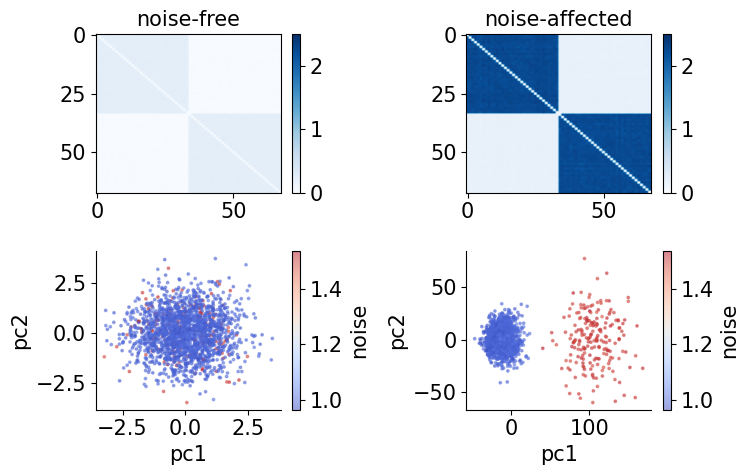

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(7.5, 5))

p1 = axes[0,0].imshow(sim_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2.5)
axes[0,0].set_title('noise-free')
cbar = plt.colorbar(p1, ax=axes[0,0])

p2 = axes[0,1].imshow(noisy_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2.5)
axes[0,1].set_title('noise-affected')
cbar = plt.colorbar(p2, ax=axes[0,1])

p3 = axes[1,0].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=sim_df, s=3, alpha=0.5)
axes[1,0].set_xlabel('pc1')
axes[1,0].set_ylabel('pc2')
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[1,0], label="noise")

p4 = axes[1,1].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=noisy_df, s=3, alpha=0.5)
axes[1,1].set_xlabel('pc1')
axes[1,1].set_ylabel('pc2')
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
cbar = plt.colorbar(p4, ax=axes[1,1], label="noise")

plt.tight_layout()

prepare torch datasets for training

In [9]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.1,
    alpha = 1, beta = 0.01, gamma = 1,
    batch_size=32, n_epochs=50, lr=1e-4, device=DEVICE)

In [16]:
ids = list(range(n_nets))
random.shuffle(ids)
train_ids = ids[:int(.9*n_nets)]
val_ids = ids[int(.9*n_nets):]
print(len(train_ids), len(val_ids))
tensor_nets = torch.stack([torch.Tensor(i) for i in list(noisy_nets)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_noises = torch.from_numpy(noises).to(torch.float32).view(-1, 1)

train_set = utils.TensorDataset(tensor_nets[train_ids], 
                        tensor_noises[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], 
                        tensor_noises[val_ids] )

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

1800 200


In [11]:
# create masks for graph convolution layers

A_mat = np.mean(noisy_nets, axis=0)
A_mat = A_mat + A_mat.transpose()
mask_knn = (np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+1)
masks = [torch.from_numpy(np.float32(mask_knn)).float() for i in range(config.n_dec_layers)]
print(len(masks), mask_knn.shape)

5 (68, 68)


vae

In [10]:
model = VAE(config).to(config.device)
model.set_mask(masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [11]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.custom_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.custom_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 2366.725 nll: 2365.385 kl: 133.934
epoch: 0 test loss 2083.331 nll: 2082.329 kl: 100.206
epoch: 5 train loss: 2062.550 nll: 2061.401 kl: 114.883
epoch: 5 test loss 1962.473 nll: 1961.375 kl: 109.751
epoch: 10 train loss: 1975.103 nll: 1974.125 kl: 97.752
epoch: 10 test loss 1989.712 nll: 1988.971 kl: 74.091
epoch: 15 train loss: 1940.829 nll: 1939.576 kl: 125.253
epoch: 15 test loss 2018.467 nll: 2017.926 kl: 54.155
epoch: 20 train loss: 1929.507 nll: 1928.023 kl: 148.370
epoch: 20 test loss 1995.991 nll: 1995.222 kl: 76.823
epoch: 25 train loss: 1911.262 nll: 1909.505 kl: 175.732
epoch: 25 test loss 1976.368 nll: 1975.322 kl: 104.631
epoch: 30 train loss: 1914.869 nll: 1913.234 kl: 163.482
epoch: 30 test loss 1951.838 nll: 1950.414 kl: 142.426
epoch: 35 train loss: 1941.739 nll: 1940.082 kl: 165.693
epoch: 35 test loss 1905.098 nll: 1903.521 kl: 157.650
epoch: 40 train loss: 1911.641 nll: 1909.678 kl: 196.333
epoch: 40 test loss 1957.024 nll: 1955.693 kl: 133.097


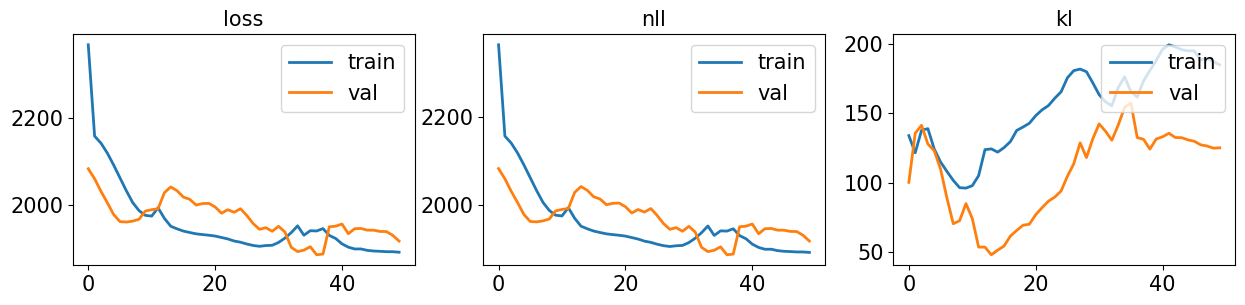

In [12]:
# diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)
plt.show()

In [ ]:
# torch.save(model.state_dict(), './pretrained/sim_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/sim_vae_pretrained.mod'))

In [13]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

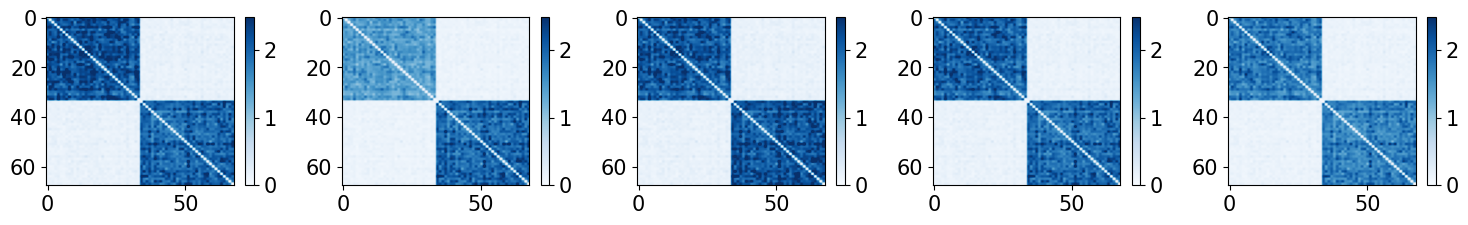

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2.5)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [15]:
pca = PCA(2)
vae_Xt = pca.fit_transform(x_recon.reshape(-1, n_nodes*n_nodes))
vae_df = pd.DataFrame({"pc1": vae_Xt[:,0], "pc2": vae_Xt[:,1], "noise": noises})

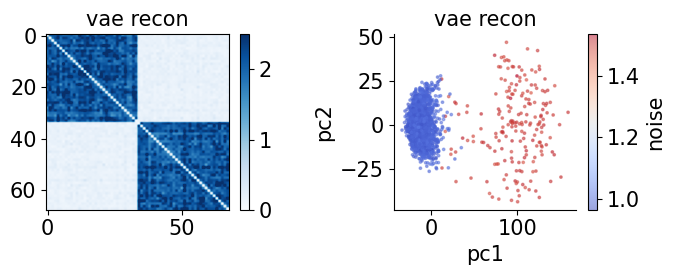

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

p1 = axes[0].imshow(x_recon.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2.5)
axes[0].set_title('vae recon')
cbar = plt.colorbar(p1, ax=axes[0])

p3 = axes[1].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=vae_df, s=3, alpha=0.5)
axes[1].set_xlabel('pc1')
axes[1].set_ylabel('pc2')
axes[1].set_title('vae recon')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[1], label="noise")

plt.tight_layout()

inv_vae

In [12]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=1,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.1,
    alpha = 0.002, beta = 0.01, gamma = 1,
    batch_size=32, n_epochs=50, lr=1e-4, device=DEVICE)

In [13]:
model = INV_VAE(config).to(config.device)
model.set_mask(masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [14]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.custom_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.custom_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 4.743 nll: 2355.509 kl: 0.770 inv_loss: 0.024
epoch: 0 test loss 4.580 nll: 2289.836 kl: 0.014 inv_loss: 0.000
epoch: 5 train loss: 4.340 nll: 2169.753 kl: 0.006 inv_loss: 0.000
epoch: 5 test loss 4.602 nll: 2300.992 kl: 0.005 inv_loss: 0.000
epoch: 10 train loss: 4.342 nll: 2171.173 kl: 0.002 inv_loss: 0.000
epoch: 10 test loss 4.603 nll: 2301.656 kl: 0.002 inv_loss: 0.000
epoch: 15 train loss: 4.343 nll: 2171.534 kl: 0.001 inv_loss: 0.000
epoch: 15 test loss 4.603 nll: 2301.690 kl: 0.001 inv_loss: 0.000
epoch: 20 train loss: 4.344 nll: 2171.759 kl: 0.000 inv_loss: 0.000
epoch: 20 test loss 4.603 nll: 2301.650 kl: 0.000 inv_loss: 0.000
epoch: 25 train loss: 4.344 nll: 2171.997 kl: 0.000 inv_loss: 0.000
epoch: 25 test loss 4.604 nll: 2301.871 kl: 0.000 inv_loss: 0.000
epoch: 30 train loss: 4.344 nll: 2171.939 kl: 0.000 inv_loss: 0.000
epoch: 30 test loss 4.603 nll: 2301.525 kl: 0.000 inv_loss: 0.000
epoch: 35 train loss: 4.344 nll: 2172.042 kl: 0.000 inv_loss: 0.00

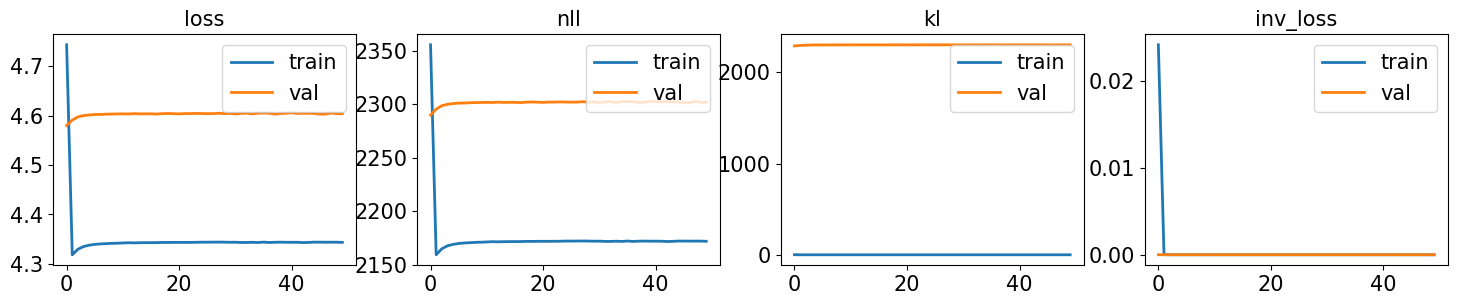

In [15]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)
plt.show()

In [ ]:
# torch.save(model.state_dict(), './pretrained/sim_inv_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/sim_inv_vae_pretrained.mod'))

In [17]:
z_mean, z_logvar = model.encode(tensor_nets.to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
x_recon = model.decode(z_sample, 
                      tensor_noises.to(config.device)
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

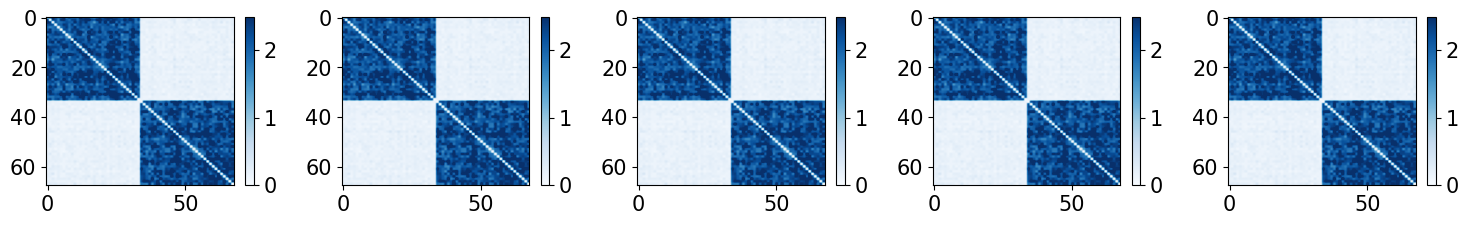

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2.5)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [19]:
pca = PCA(2)
inv_vae_Xt = pca.fit_transform(x_recon.reshape(-1, n_nodes*n_nodes))
inv_vae_df = pd.DataFrame({"pc1": inv_vae_Xt[:,0], "pc2": inv_vae_Xt[:,1], "noise": noises})

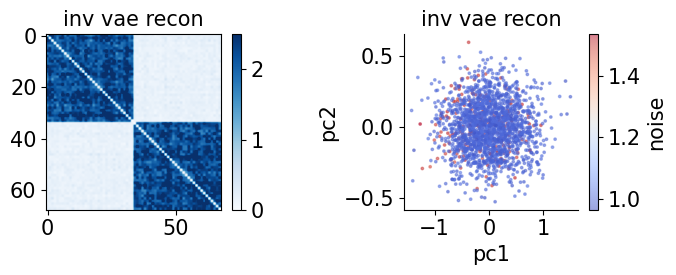

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

p1 = axes[0].imshow(x_recon.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2.5)
axes[0].set_title('inv vae recon')
cbar = plt.colorbar(p1, ax=axes[0])

p3 = axes[1].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=inv_vae_df, s=3, alpha=0.5)
axes[1].set_xlabel('pc1')
axes[1].set_ylabel('pc2')
axes[1].set_title('inv vae recon')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[1], label="noise")

plt.tight_layout()